In [1]:
%matplotlib inline
from ftplib import FTP
import tempfile
import pandas as pd
import numpy as np
import re  # regex searching
import matplotlib.pyplot as plt

In [2]:
ftp = FTP('ftp.ncdc.noaa.gov')
ftp.login()
ftp.cwd('/pub/data/normals/1981-2010/products/temperature/')

'250 CWD command successful'

In [3]:
DAILY_FILE_NAMING = 'dly-*-normal.txt'
DAILY_COLUMNS = [('%d' % i) for i in xrange(1,32)]
DAILY_COLUMNS.insert(0, 'MONTH')
DAILY_COLUMNS.insert(0, 'STNID')

In [4]:
NON_NUMERIC_REGEX = re.compile(r'[^\d.]+')
SPECIAL_VALUES = ['-7777', '-8888', '-9999', '-6666', '-5555']  # columns that represent a specific type of NULL data
def process_value_column(string):
    if string in SPECIAL_VALUES:
        return np.nan
    deg = NON_NUMERIC_REGEX.sub('', string)
    deg = float(deg[-3:-1] + '.' + deg[-1])        
    return float(deg)  # return Flag as well.

In [5]:
def process_dataframe(df, value):
    """Process dataframe, setting indexes, etc."""
    value = value.upper()
    df = pd.melt(df, id_vars=['STNID', 'MONTH'], var_name='DAY', value_name=value)
    df[value + '_FLAG'] = df[value].map(lambda s: s[-1])
    df[value] = df[value].apply(process_value_column)
    df['DAY'] = df['DAY'].apply(int)
    df['MONTH'] = df['MONTH'].apply(int)
    df = df.sort_values(['STNID','MONTH', 'DAY'])
    df = df.set_index(['STNID', 'MONTH', 'DAY'])
    return df

In [6]:
def parse_file(filename, columns):
    """Parse a daily weather file."""
    tempf = tempfile.mktemp()
    ftp.retrbinary('RETR %s' % filename, open(tempf, 'wb').write)
    df = pd.read_fwf(open(tempf, 'r'), header=None, names=columns, index_col=None)
    value = re.search(r'dly-(.*)-normal.txt', filename).group(1)
    return process_dataframe(df, value)

In [7]:
# Downloading list of stations
# df = pd.DataFrame(columns=DAILY_COLUMNS)
dfs = []
for filename in ftp.nlst(DAILY_FILE_NAMING):
    filetype = re.search(r'dly-(.*)-normal.txt', filename).group(1)
    # print('Filetype: %s' % filetype)
    df = parse_file(filename, DAILY_COLUMNS)
    dfs.append(df)

In [11]:
# Combines list of DataFrames into one
data = pd.concat(dfs, axis=1)

In [23]:
data.head()

,STNID,MONTH,DAY,TMIN,TMIN_FLAG,TMAX,TMAX_FLAG,TAVG,TAVG_FLAG,HTDD,HTDD_FLAG,DUTR,DUTR_FLAG,CLDD,CLDD_FLAG
0,AQW00061705,1,1,77.2,C,87.5,C,82.4,C,0.0,C,10.3,C,1.7,C
1,AQW00061705,1,2,77.2,C,87.5,C,82.4,C,0.0,C,10.3,C,1.7,C
2,AQW00061705,1,3,77.2,C,87.5,C,82.4,C,0.0,C,10.3,C,1.7,C
3,AQW00061705,1,4,77.2,C,87.5,C,82.4,C,0.0,C,10.3,C,1.7,C
4,AQW00061705,1,5,77.2,C,87.5,C,82.4,C,0.0,C,10.3,C,1.7,C


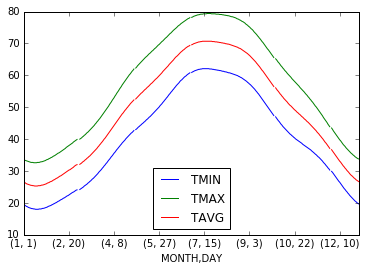

In [21]:
data = data.reset_index(drop=False)
data[data['STNID'] == 'USC00068138'].set_index(['MONTH', 'DAY'])[['TMIN', 'TMAX', 'TAVG']].plot()